In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, precision_score, f1_score 


In [2]:
epileptic = pd.read_csv("Epileptic Seizure Recognition.csv", index_col='Unnamed')
epileptic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11500 entries, X21.V1.791 to X16.V1.210
Columns: 179 entries, X1 to y
dtypes: int64(179)
memory usage: 15.8+ MB


In [3]:
# Select the independent variable and identify the dependent variables
X = epileptic.drop(columns='y')
y = epileptic.y

#Split data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8050, 178) (8050,)
(3450, 178) (3450,)


1 1636
2 1600
3 1615
4 1610
5 1589


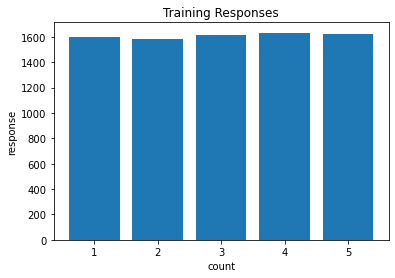

In [4]:
# count of each response in training set
response_list = [1, 2, 3, 4, 5]
for y in response_list:
    print(y, y_train[y_train == y].count())

height = [1599, 1579, 1615, 1632, 1625]
    
# chart the data 
plt.bar(response_list, height=[1599, 1579, 1615, 1632, 1625])


# add title and axis names
plt.title('Training Responses')
plt.xlabel('count')
plt.ylabel('response')
 
# show graph
plt.show()

1 664
2 700
3 685
4 690
5 711


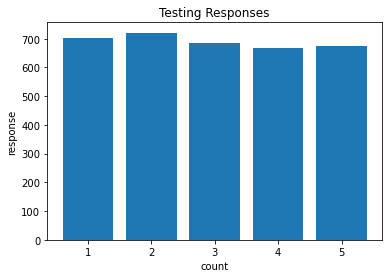

In [5]:
# count of each response in test set
for y in response_list:
    print(y, y_test[y_test == y].count())
    
# chart the data 
plt.bar(response_list, height=[701, 721, 685, 668, 675])

# add title and axis names
plt.title('Testing Responses')
plt.xlabel('count')
plt.ylabel('response')
 
# show graph
plt.show()

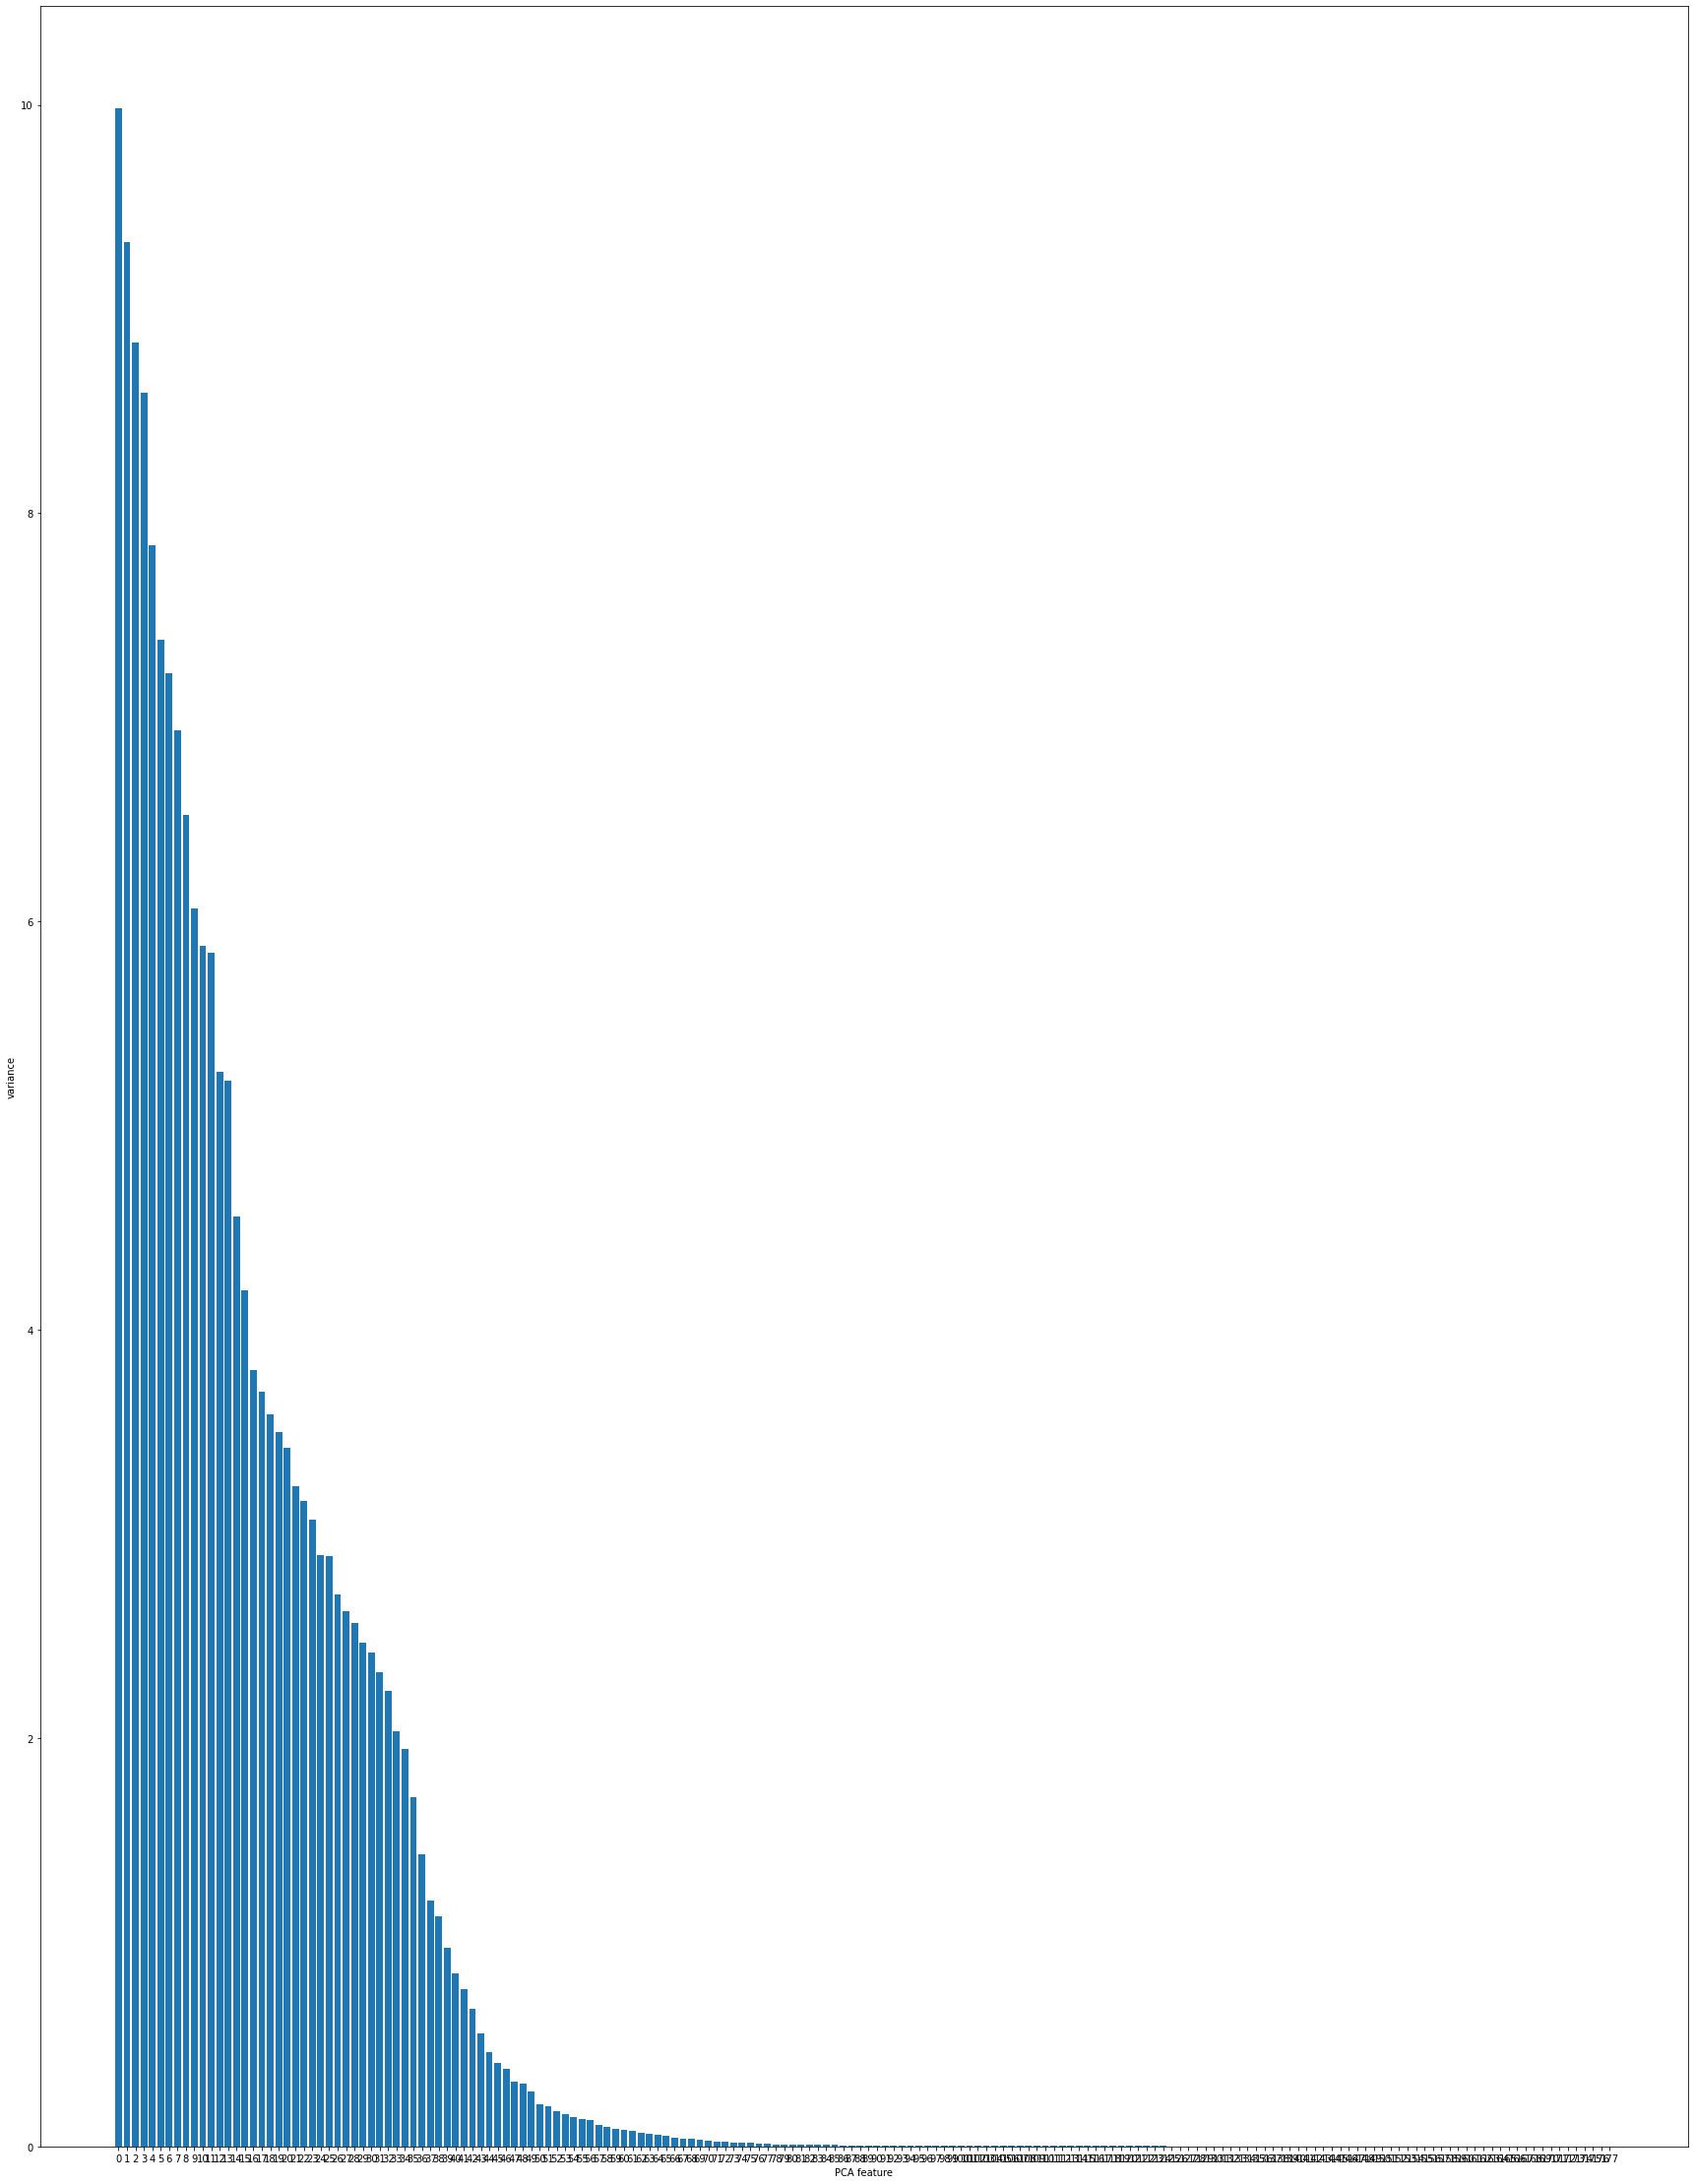

In [6]:
# Rows of transformed correspond to sampels 
# Colunms of transformed are the "PCA features"

# Create Scaler 
scaler = StandardScaler()

# Create PCA instance 
pca = PCA()

# Create pipeline
pipeline = make_pipeline(scaler, pca)

# Fit pipeline to samples 
pipeline.fit(X)

#Plot explained variance 
plt.figure(figsize=(30, 40))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [20]:
#pentalty: ('none','l2','l1','elasticnet'); dual: only implemented for l2 penalty
#C=1.0, fit_intercept=True,intercept_scaling=1, random_state=None,l1_ratio=None

## Instatiate LogisticRegression estimator
lr = LogisticRegression(tol=0.0001,
                        class_weight='balanced',
                        solver='newton-cg', 
                        max_iter=100, 
                        multi_class='multinomial', 
                        verbose=1, 
                        warm_start=False, 
                        n_jobs=-1)

##  Instatiate RandomForest classifier 
rf = RandomForestClassifier(n_jobs=2, random_state=0, verbose=1)

## Instatiate AdaBoost classifier
ab = AdaBoostClassifier(n_estimators=1000, learning_rate=3.0, algorithm='SAMME', random_state=0)

In [21]:
def pos_proba(clf, X_train, y_train, X_test):
    #scale the data 
    clf_pipe = make_pipeline(StandardScaler(), clf)

    # Fit the model on the training data
    clf_pipe.fit(X_train, y_train)

    # Probability that a particular data point falls into the underlying class
    y_pred = clf_pipe.predict_proba(X_test)

    #Shape y_pred in 1D shape
    flat_ypred = np.argmax(y_pred, axis = 1)

    return clf_pipe, y_pred, flat_ypred  

In [22]:
# LogisticRegression class probabilities
lr_pipe, lry_pred, lrflat_ypred = pos_proba(lr, X_train, y_train, X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.2s finished


In [23]:
# RandomForest class probabilities
rf_pipe, rfy_pred, rfflat_ypred = pos_proba(rf, X_train, y_train, X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [24]:
# AdaBoost class probabilities
ab_pipe, aby_pred, abflat_ypred = pos_proba(ab, X_train, y_train, X_test)

5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed

3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

2 - They recorder the EEG from the area where the tumor was located

1 - Recording of seizure activity

In [25]:
#Calculate confusion matrices

# LogisticRegression class probabilities
lr_cm = confusion_matrix(y_test, lrflat_ypred)

# RandomForest class probabilities
rf_cm = confusion_matrix(y_test, rfflat_ypred)

# AdaBoost class probabilities
ab_cm = confusion_matrix(y_test, abflat_ypred)

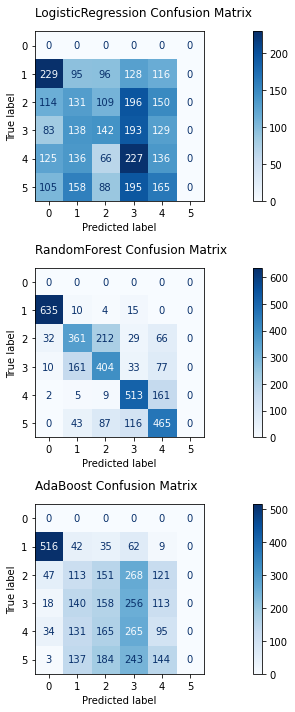

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# plotting subplots
lrd = ConfusionMatrixDisplay(confusion_matrix=lr_cm)
lrd.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('LogisticRegression Confusion Matrix', loc='left', pad=15)

rfd = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
rfd.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('RandomForest Confusion Matrix', loc='left', pad=15)

abd = ConfusionMatrixDisplay(confusion_matrix=ab_cm)
abd.plot(ax=axes[2], cmap=plt.cm.Blues)
axes[2].set_title('AdaBoost Confusion Matrix', loc='left', pad=15)

# automatically adjust padding horizontally
# as well as vertically.
plt.tight_layout()
 
# display plot
plt.show()



In [27]:
def classOpVal(y_test, y_pred, flat_ypred, clf_pipe):
    # Calculate AUROC
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    # Calculate ROC curve 
    r_fpr, r_tpr, _ = roc_curve(y_test, flat_ypred, pos_label=lr_pipe.classes_[1])
    
    return auc, r_fpr, r_tpr

In [28]:
# LogisticRegression classification threshold
lr_auc, lr_fpr, lr_tpr = classOpVal(y_test, lry_pred, lrflat_ypred, lr_pipe)

# RandomForest classification threshold
rf_auc, rf_fpr, rf_tpr = classOpVal(y_test, rfy_pred, rfflat_ypred, rf_pipe)

# AdaBoost classification threshold
ab_auc, ab_fpr, ab_tpr = classOpVal(y_test, aby_pred, abflat_ypred, ab_pipe)

Logistic Regression AUROC: 0.5321634290285309
RandomForest AUROC: 0.910069789942028
AdaBoost AUROC: 0.6562872652057228


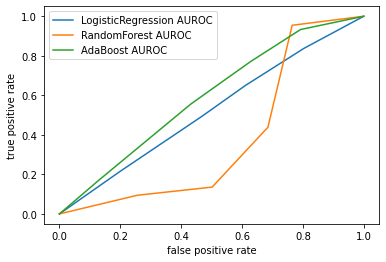

In [29]:
print("Logistic Regression AUROC:", lr_auc)
plt.plot(lr_fpr, lr_tpr, linestyle='-', label="LogisticRegression AUROC" % lr_auc)

print("RandomForest AUROC:", rf_auc)
plt.plot(rf_fpr, rf_tpr, linestyle='-', label="RandomForest AUROC" % rf_auc)

print("AdaBoost AUROC:", ab_auc)
plt.plot(ab_fpr, ab_tpr, linestyle='-', label="AdaBoost AUROC" % ab_auc)

# set axis labels
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

 
# display plot
plt.legend()
plt.show()


In [30]:
# Logistic Regression f1_score
lr_f1 = f1_score(y_test, lrflat_ypred, pos_label=1, average='macro', sample_weight=None, zero_division='warn')
print('Logistic Regression F1 Score:', lr_f1)

# RandomForest f1_score
rf_f1 = f1_score(y_test, rfflat_ypred, pos_label=1, average='macro', sample_weight=None, zero_division='warn')
print('Random Forest F1 Score:', rf_f1)

# AdaBoost f1_score
ab_f1 = f1_score(y_test, abflat_ypred, pos_label=1, average='macro', sample_weight=None, zero_division='warn')
print('AdaBoost F1 Score:', ab_f1)

Logistic Regression F1 Score: 0.1265283271717376
Random Forest F1 Score: 0.09727653114482111
AdaBoost F1 Score: 0.12252935196476765
